In [2]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
class MaskedConv2d(nn.Conv2d):
    """
    Class extending nn.Conv2d to use masks.
    """
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).float())
        if kernel_size > 1:
            center = kernel_size // 2
            if mask_type == 'A':
                self.mask[:,:,center,center:] = 0
                self.mask[:,:,center+1:,:] = 0
            else:
                self.mask[:,:,center,center+1:] = 0
                self.mask[:,:,center+1:,:] = 0
            
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [4]:
class PixelCNN(nn.Module):
    def __init__(self, in_channels, num_layers=8, kernel_size=7, num_filters=64):
        super(PixelCNN, self).__init__()

        layers = []
        layers.append(MaskedConv2d(mask_type='A', in_channels=in_channels, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2))
        layers.append(nn.ReLU())
 
        for _ in range(num_layers - 3):
            layers.append(MaskedConv2d(mask_type='B', in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2))
            layers.append(nn.ReLU())
        
        layers.append(MaskedConv2d(mask_type='B', in_channels=num_filters, out_channels=num_filters, kernel_size=1))
        layers.append(nn.ReLU())
        layers.append(MaskedConv2d(mask_type='B', in_channels=num_filters, out_channels=in_channels, kernel_size=1))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = PixelCNN(in_channels=1, num_layers=8, kernel_size=7, num_filters=64)
print(model)

PixelCNN(
  (net): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (11): ReLU()
    (12): MaskedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU()
    (14): MaskedConv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (15): Sigmoid()
  )
)


In [5]:
def download_data(path, batch_size):
    transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

    train_dataset = datasets.MNIST(root=path, train=True, download=False, transform=transform)
    test_dataset = datasets.MNIST(root=path, train=False, download=False, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader
train_dataloader, test_dataloader = download_data(path='./data', batch_size=32)

In [6]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for images, _ in dataloader:
        images = images.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    return train_loss / len(dataloader)

In [7]:
def evaluate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()

    return val_loss / len(dataloader)

In [8]:
criterion = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
model.to(device)
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
    torch.save(model.state_dict(), 'pixelcnn_model_f.pth')
    test_loss = evaluate_one_epoch(model, test_dataloader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss : {train_loss:.6f}, Test Loss: {test_loss:.6f}")

c:\Users\Ali\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10, Train Loss : 0.106133, Test Loss: 0.083636
Epoch 2/10, Train Loss : 0.082642, Test Loss: 0.081110
Epoch 3/10, Train Loss : 0.080610, Test Loss: 0.079935
Epoch 4/10, Train Loss : 0.079252, Test Loss: 0.078216
Epoch 5/10, Train Loss : 0.078229, Test Loss: 0.077816
Epoch 6/10, Train Loss : 0.077468, Test Loss: 0.076818
Epoch 7/10, Train Loss : 0.076858, Test Loss: 0.076920
Epoch 8/10, Train Loss : 0.076373, Test Loss: 0.076786
Epoch 9/10, Train Loss : 0.075962, Test Loss: 0.076165
Epoch 10/10, Train Loss : 0.075590, Test Loss: 0.075969


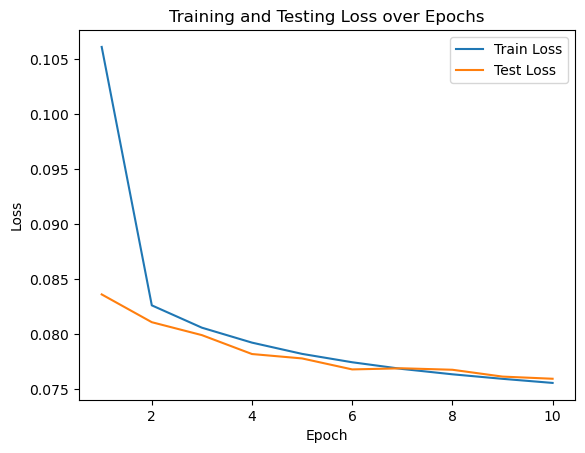

In [10]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend() 
plt.show()

In [11]:
def sample_from_pixelcnn(model, shape=(100, 1, 28, 28)):
    model.eval()
    samples = torch.zeros(shape).to(next(model.parameters()).device)
    
    with torch.no_grad():
        for i in range(shape[2]):
            for j in range(shape[3]):
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j])
    return samples

In [12]:
sampled_images = sample_from_pixelcnn(model, shape=(100, 1, 28, 28))
print(sampled_images.shape)

torch.Size([100, 1, 28, 28])


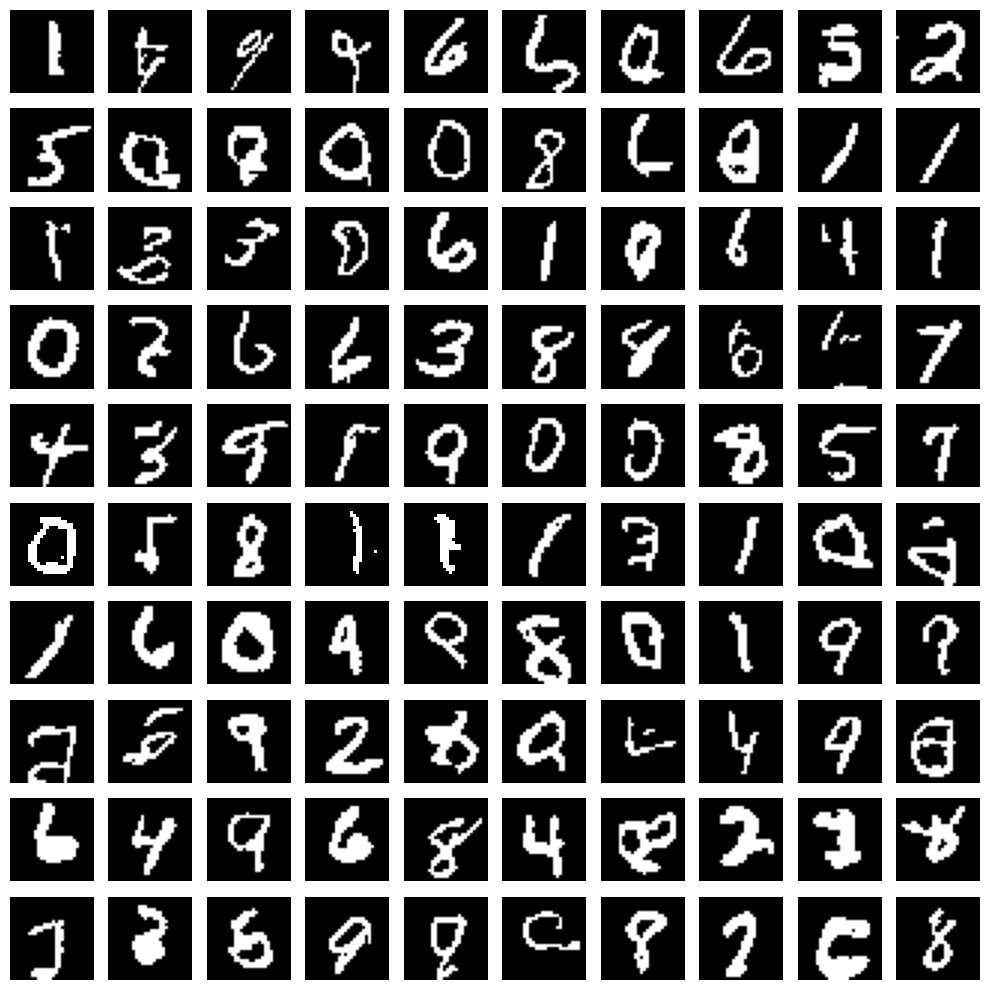

In [13]:
# Plot the generated samples
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(sampled_images[i].squeeze().cpu().numpy(), cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()